<a href="https://colab.research.google.com/github/serrve1/kdigital/blob/main/%EA%B2%BD%EA%B8%B0%EB%B6%84%EC%84%9D%2Ck_means(k%3D4)%2Cmeanshift%2C_minmax%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 한글폰트
# 나눔고딕 폰트 설치
!apt-get -qq -y install fonts-nanum > /dev/null
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 한글 폰트 설정
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name)

# 런타임 다시 시작 (이 작업은 Colab에서 한 번만 수행하면 됨)
# Runtime -> Restart runtime 선택하거나 Ctrl+M . 입력 후 선택

In [2]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [34]:
# 데이터프레임 불러오기
economics = pd.read_csv('/content/drive/MyDrive/프로젝트1/dataset/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [35]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,M2통화량,신규실업수당청구,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,M2통화량,신규실업수당청구,경기동행종합,산업생산지수,소매판매


In [37]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [38]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [39]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

In [41]:
# 인덱스 확인
economics.head(3)

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,,,,,
2000-01-31,0.92,0.07,27.26,4.00,1636.00,0.57,-0.19,0.58,112.00,5.45,337504.00,288400.00,0.20,91.43,0.28,1.48
2000-02-29,0.64,-0.11,29.37,4.10,1737.00,0.57,-0.20,0.59,111.30,5.73,337504.00,293750.00,0.20,91.74,0.28,1.48
2000-03-31,0.15,-0.47,29.84,4.00,1604.00,0.89,-0.13,0.61,107.10,5.85,370003.00,274750.00,0.43,92.09,0.66,1.17


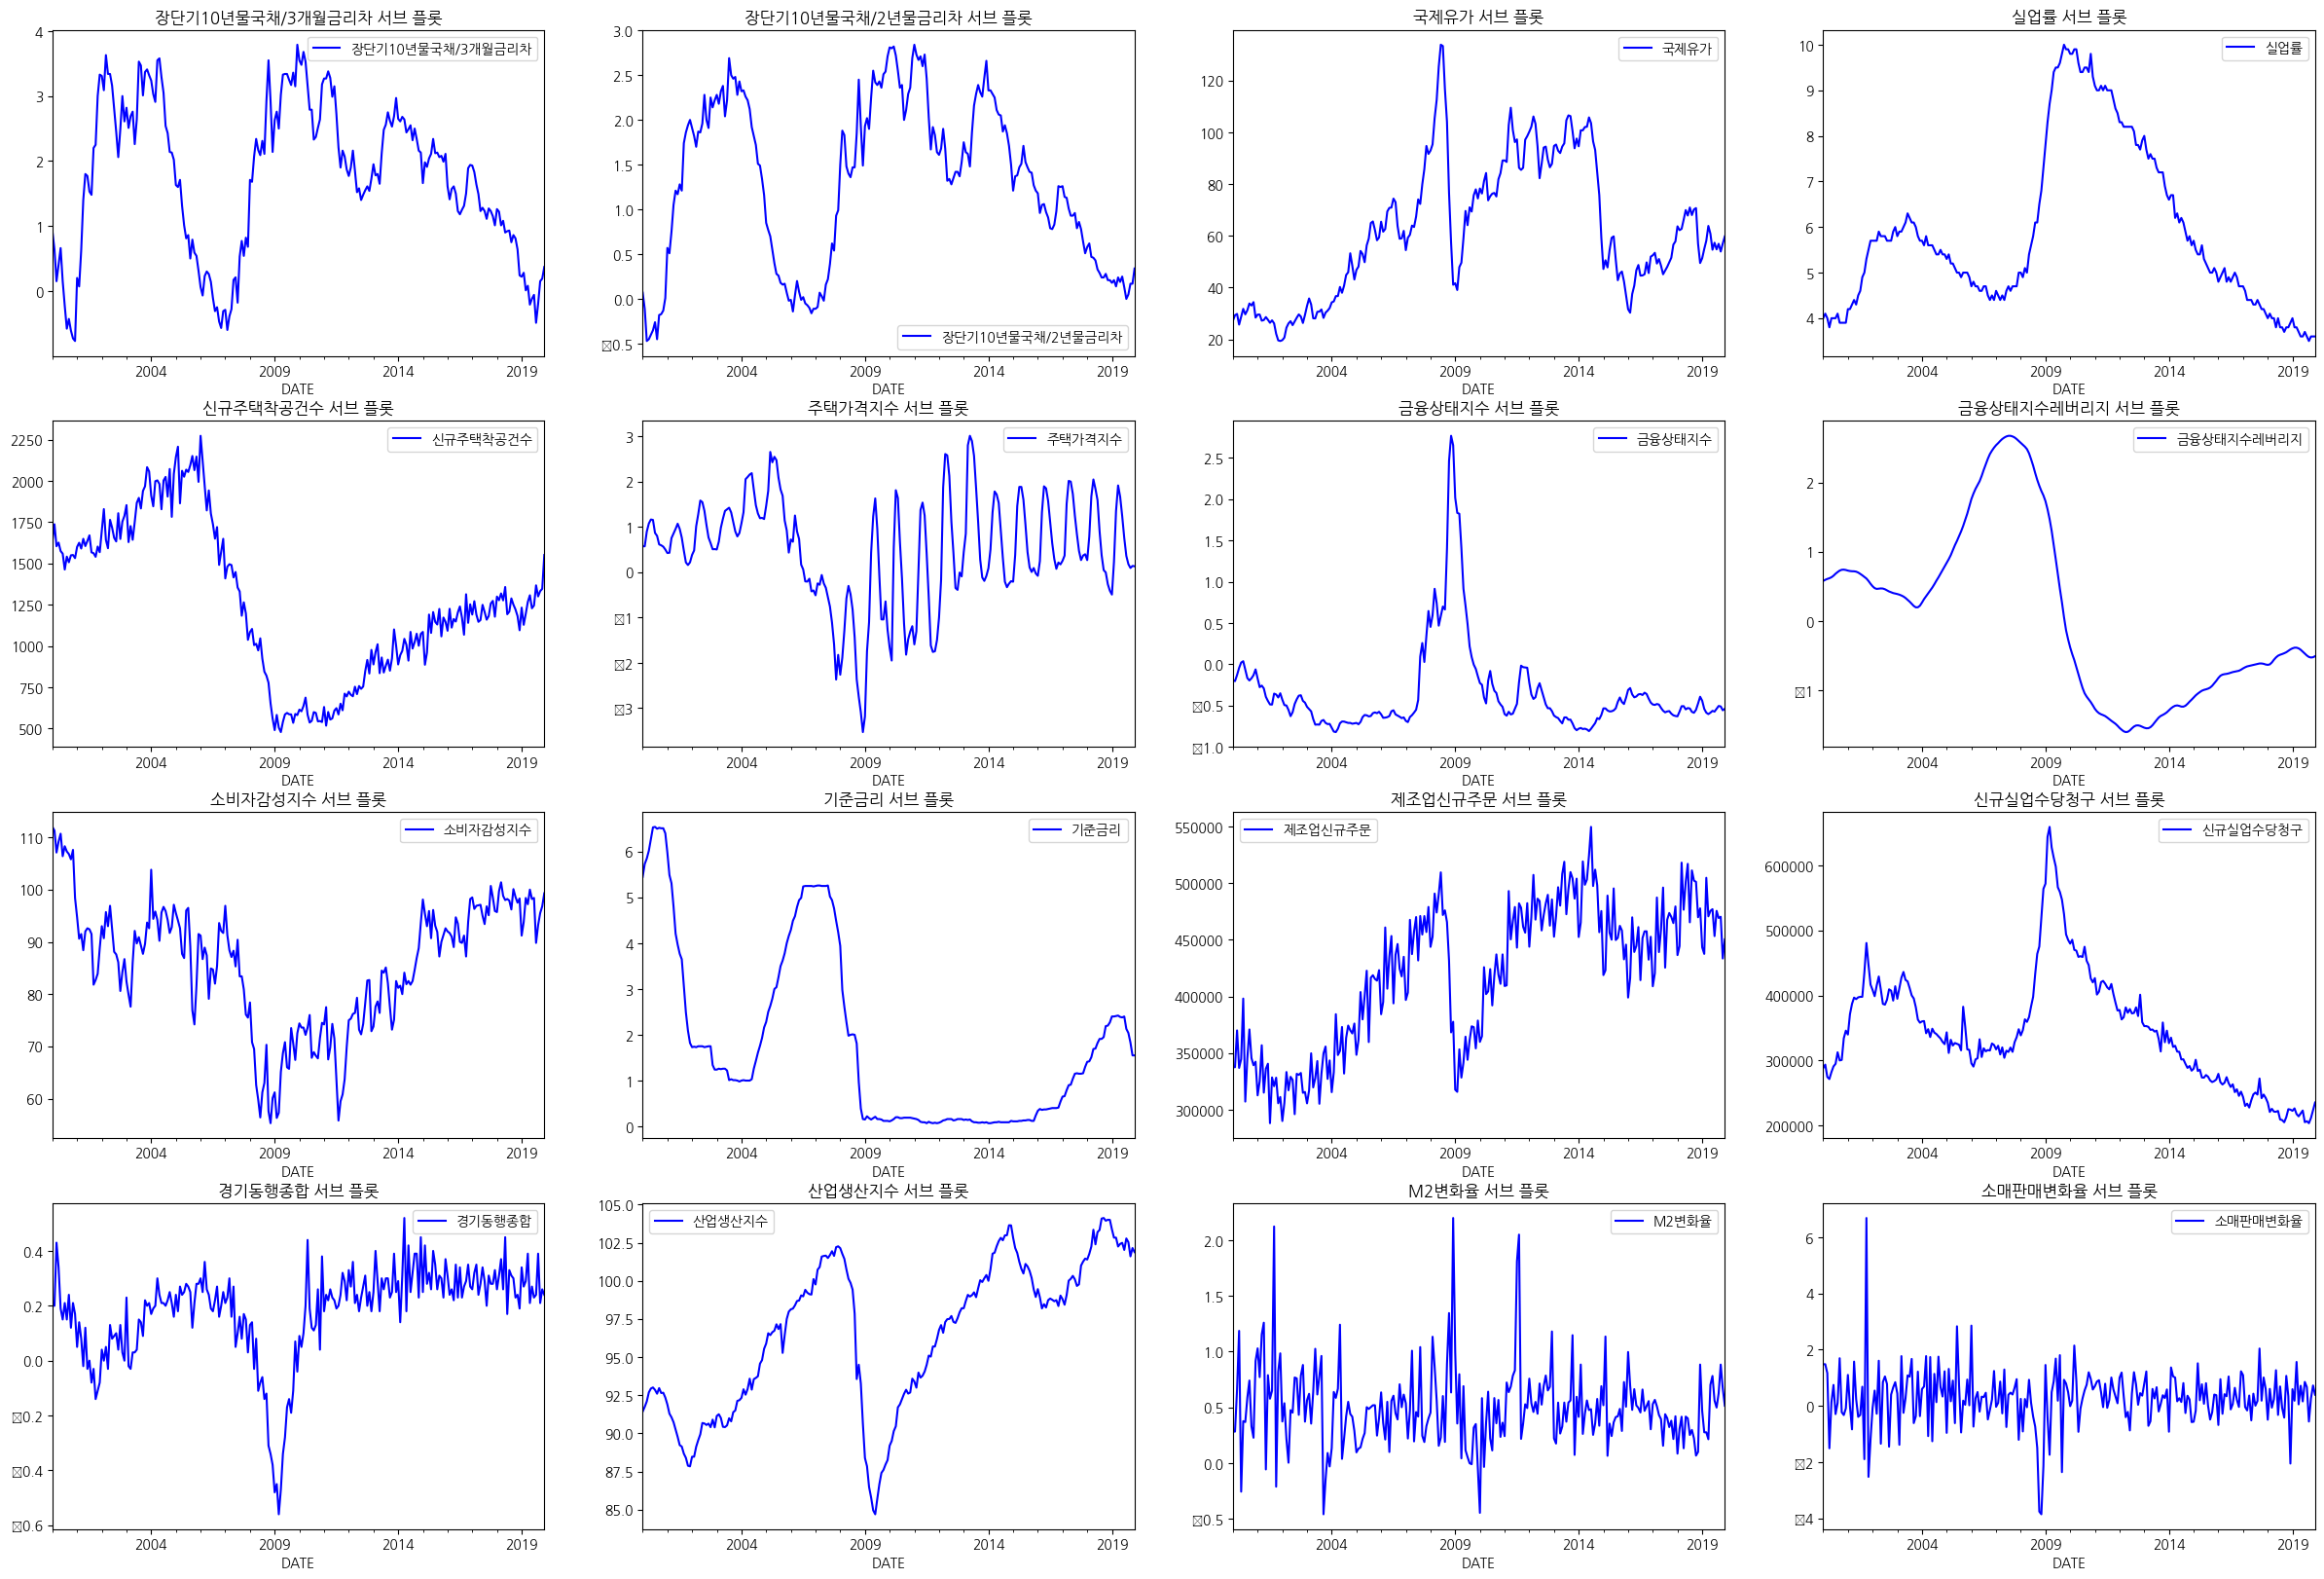

In [42]:
# 원데이터를 간단하게 시각화 해서 보기
plt.rc('font', family='NanumGothic')
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(economics.columns):
    economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()


#### 스케일링

1. min-max : 0~1까지인데 이건 시간적으로 상승하는데이터는
좋지 않아보임

2. StandardScaler

In [12]:
# # scikit-learn 패키지의 StandardScaler 클래스를 불러옵니다.
# from sklearn.preprocessing import StandardScaler
# # StandardScaler 객체를 생성합니다.
# standard_scaler = StandardScaler()
# # fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
# scaled_eocs = standard_scaler.fit_transform(economics)
# # 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
# scaled_eocs = pd.DataFrame(scaled_eocs,
#                               index=economics.index,
#                               columns=economics.columns)
# # 표준화가 잘 되었는지 데이터를 확인해봅시다.
# scaled_eocs.head()

In [43]:
# 민멕스 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(economics)

# 데이터 변환
mMscaled_data = mMscaler.transform(economics)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(data = mMscaled_data, index = economics.index , columns = economics.columns)

In [45]:
mMscaled_data.head(3)

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,,,,,
2000-01-31,0.37,0.16,0.07,0.08,0.65,0.63,0.18,0.51,1.00,0.83,0.19,0.19,0.70,0.35,0.28,0.51
2000-02-29,0.31,0.11,0.09,0.09,0.70,0.63,0.17,0.51,0.99,0.87,0.19,0.20,0.70,0.36,0.28,0.51
2000-03-31,0.20,0.00,0.09,0.08,0.63,0.68,0.19,0.52,0.91,0.89,0.31,0.16,0.92,0.38,0.42,0.48


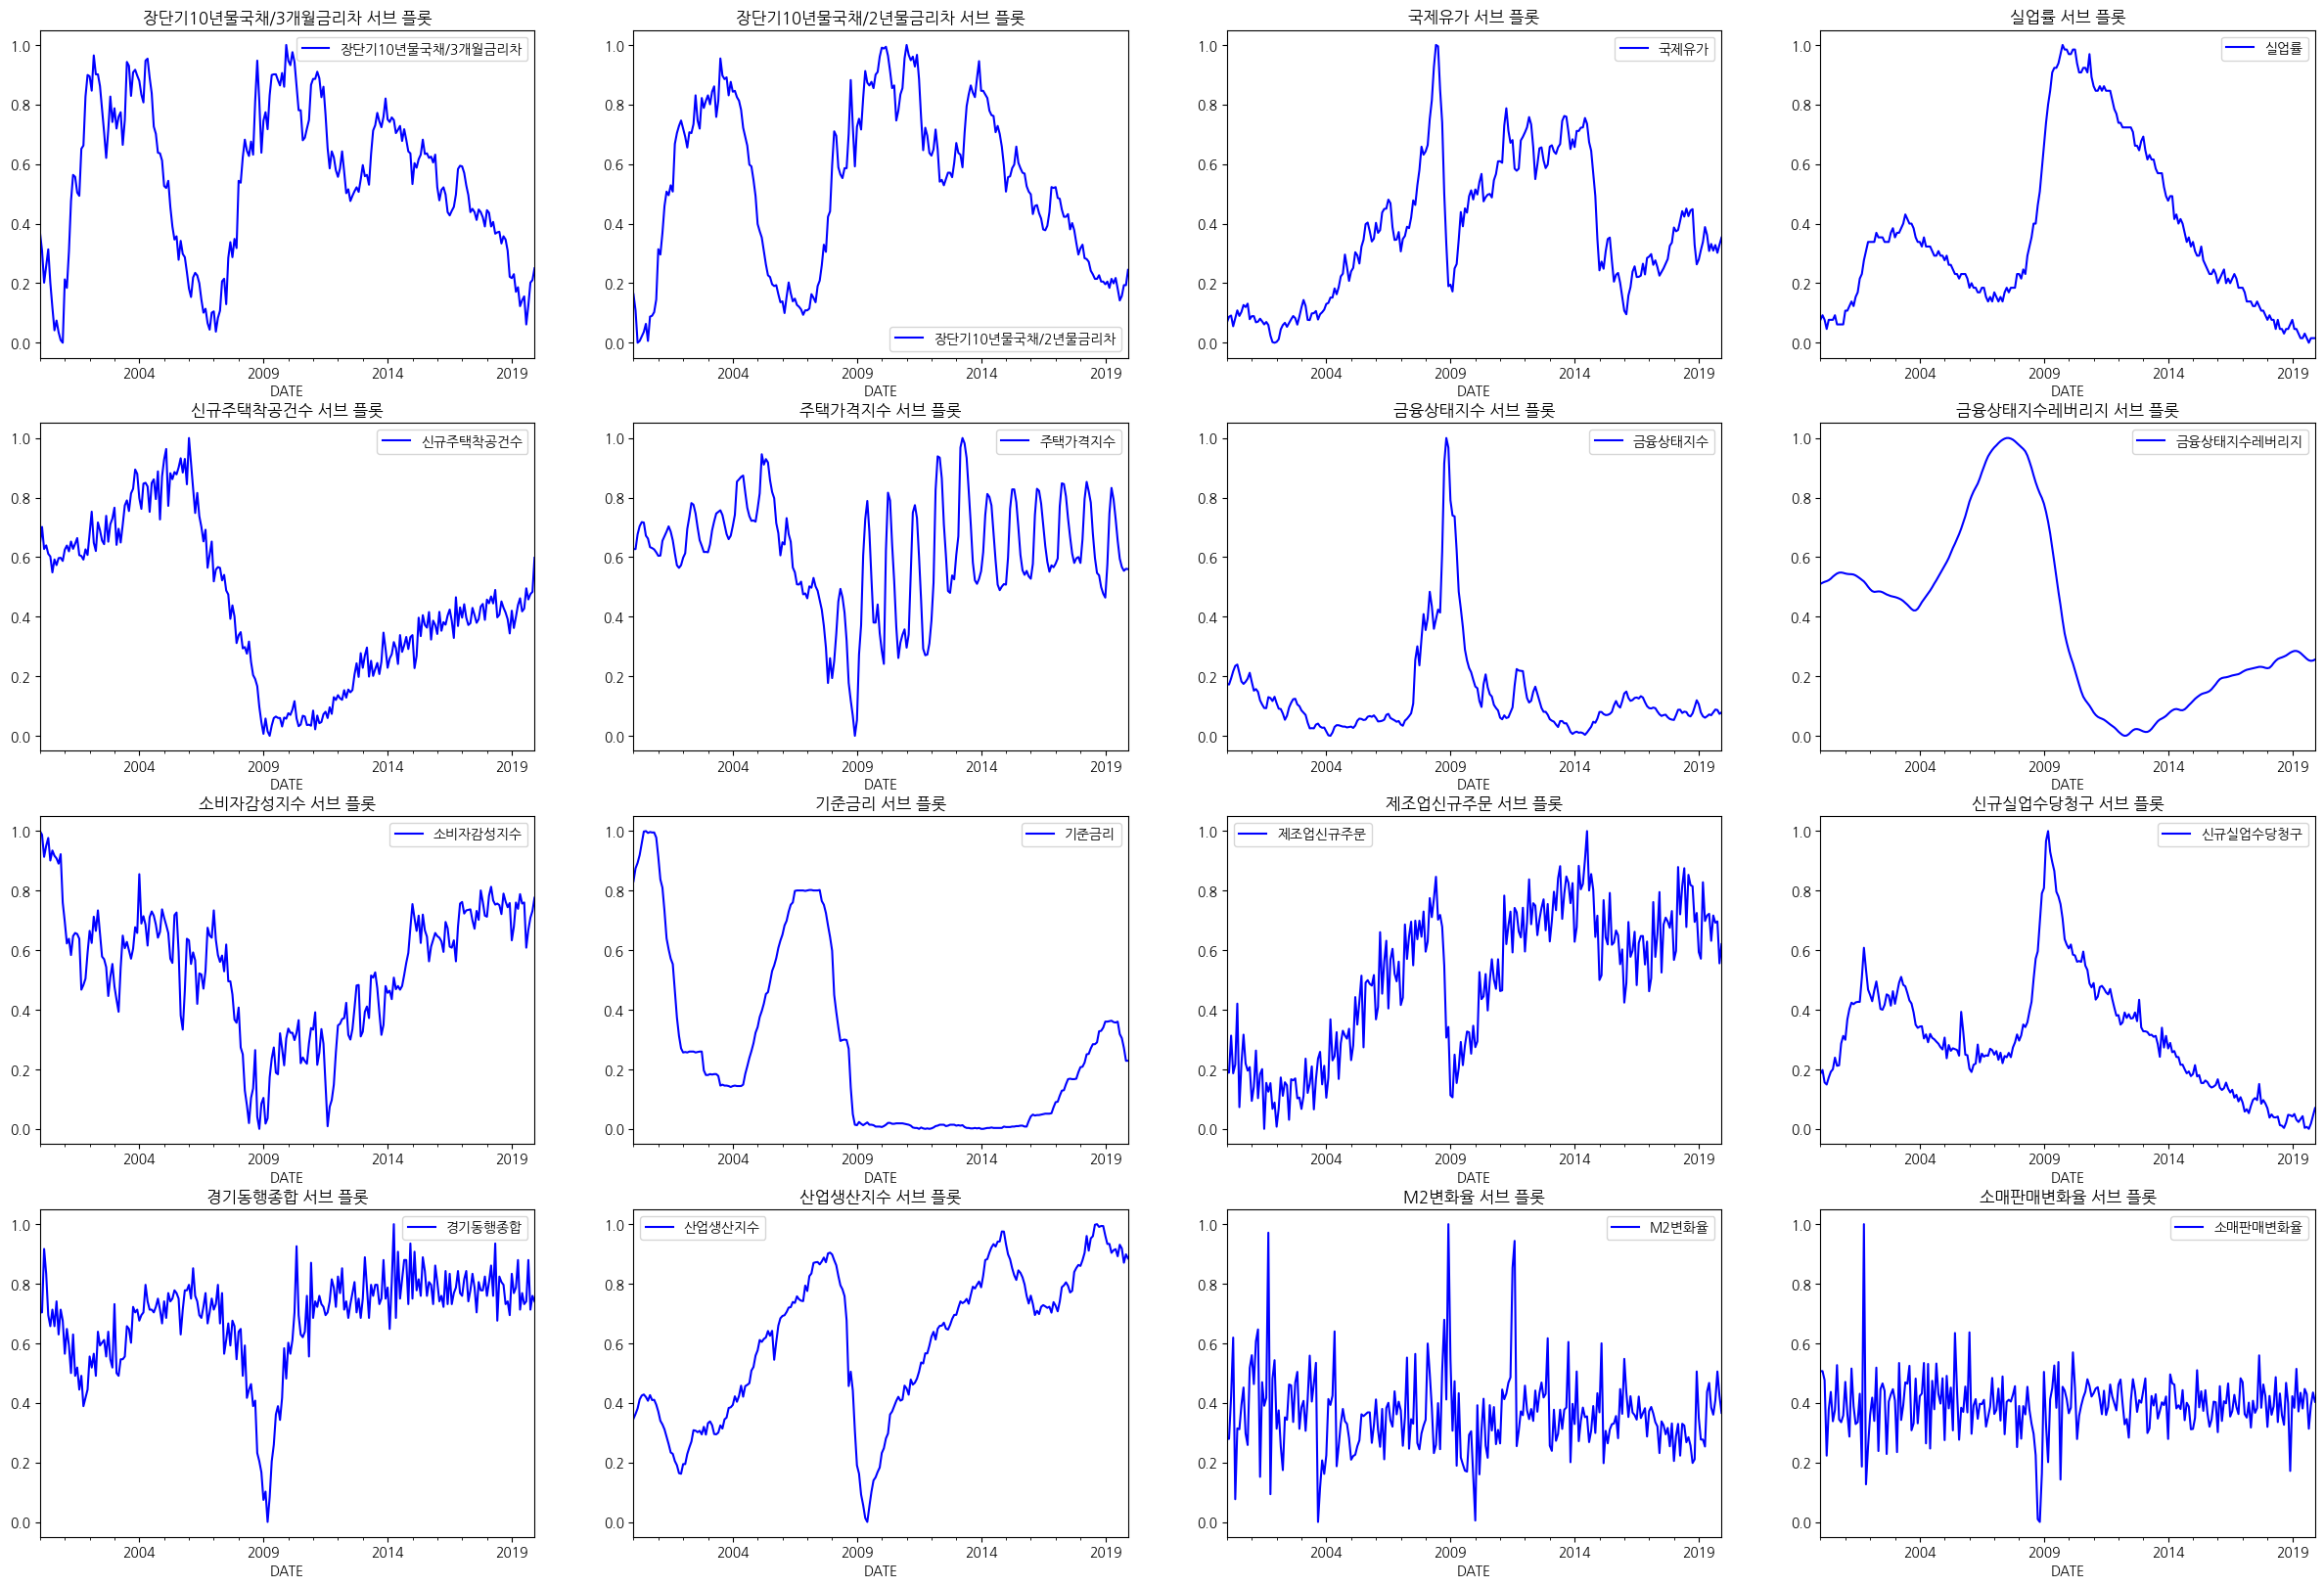

In [46]:
# 민멕스 스케일링한 데이터를 간단하게 시각화 해서 보기
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(mMscaled_data.columns):
    mMscaled_data.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

In [50]:
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px


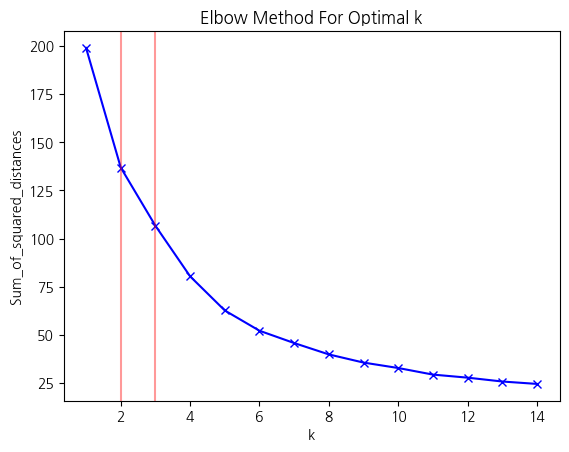

In [52]:
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(mMscaled_data) # 데이터프레임 입력
    sum_of_squared_distances.append(km.inertia_)

# 시각화

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(2,c= 'r',alpha =0.4)
plt.axvline(3,c= 'r',alpha =0.4)
plt.show()

In [53]:
k_range = range(2,14)

best_n = -1
best_silhouette_score = -1

for k in k_range:

  kmeans = KMeans(n_clusters=k, random_state=200)
  kmeans.fit(mMscaled_data)#데이터프레임
  clusters = kmeans.predict(mMscaled_data)#데이터프레임입력

  score = silhouette_score(mMscaled_data, clusters)
  print('k :',  k, 'score :', score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score

print('best n :', best_n, 'best score :', best_silhouette_score )

# k-means에서 최적의 k= 5로 판명

k : 2 score : 0.31685352864735994
k : 3 score : 0.31564143461341204
k : 4 score : 0.36193528677267656
k : 5 score : 0.4022348822013148
k : 6 score : 0.42067545034482035
k : 7 score : 0.40621208289941074
k : 8 score : 0.4202229176639968
k : 9 score : 0.3887874329660599
k : 10 score : 0.38282084109311426
k : 11 score : 0.3829619805170545
k : 12 score : 0.3608623366973736
k : 13 score : 0.36825947689712835
best n : 6 best score : 0.42067545034482035


In [55]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

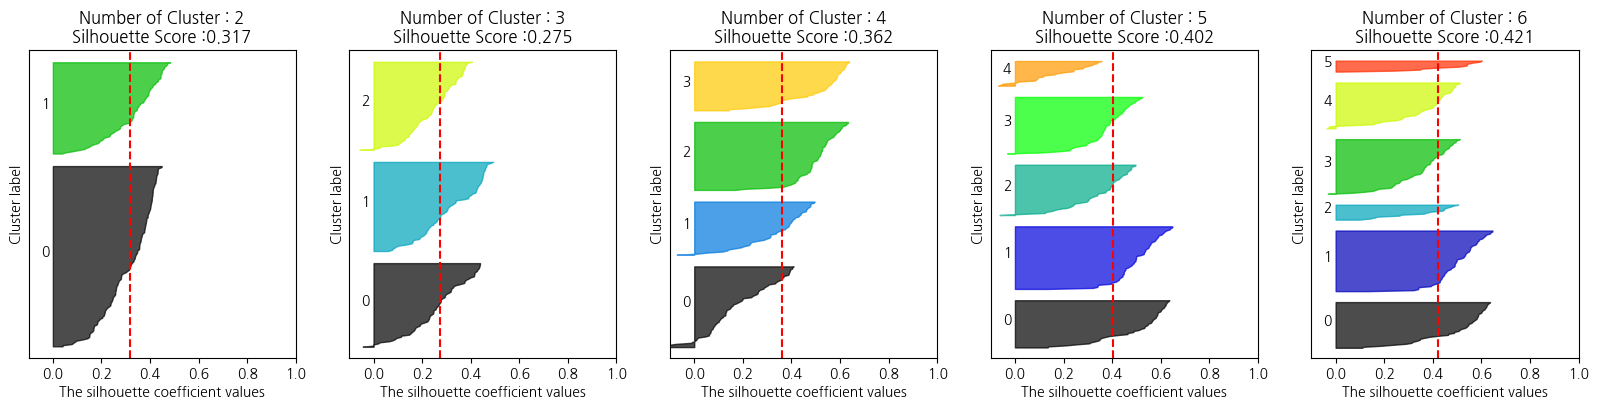

In [56]:
# 군집 개수 최적화
visualize_silhouette([ 2, 3, 4, 5 , 6], mMscaled_data)

In [57]:
# 여러 결과를 참고하여 k = 4를 기준으로 시행하였습니다.

# KMeans
kmeans = KMeans(n_clusters=4, init="k-means++", max_iter=300, random_state=200)
kmeans.fit(mMscaled_data)

# 데이터 프레임에 cluster 추가
mMscaled_data["cluster"] = kmeans.labels_

# 개별 데이터 실루엣 계수
score_samples = silhouette_samples(mMscaled_data, mMscaled_data.cluster)
print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# 데이터 프레임에 실루엣 계수 추가
mMscaled_data['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수
average_score = silhouette_score(mMscaled_data, mMscaled_data.cluster)
print(f'경제데이터 Silhouette Analysis Score: {average_score:.3f}')


silhouette_samples( ) return 값의 shape: (240,)
경제데이터 Silhouette Analysis Score: 0.564


In [58]:
mMscaled_data.groupby("cluster").mean()[["silhouette_coeff"]]

,silhouette_coeff
cluster,
0,0.63
1,0.66
2,0.41
3,0.62


In [60]:
# 0번 군집을 확인해봅니다.
mMscaled_data[mMscaled_data['cluster']== 0]

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster,silhouette_coeff
DATE,,,,,,,,,,,,,,,,,,
2001-04-30,0.48,0.46,0.07,0.14,0.65,0.67,0.15,0.54,0.58,0.73,0.10,0.42,0.50,0.31,0.65,0.52,0,0.49
2001-05-31,0.56,0.51,0.08,0.12,0.63,0.69,0.12,0.54,0.65,0.64,0.18,0.42,0.63,0.29,0.15,0.39,0,0.54
2001-06-30,0.56,0.50,0.07,0.15,0.65,0.70,0.11,0.54,0.66,0.60,0.20,0.42,0.49,0.26,0.47,0.33,0,0.57
2001-07-31,0.50,0.53,0.06,0.17,0.66,0.69,0.09,0.53,0.65,0.57,0.00,0.43,0.52,0.23,0.39,0.34,0,0.58
2001-08-31,0.49,0.51,0.07,0.22,0.61,0.66,0.09,0.53,0.64,0.55,0.15,0.43,0.44,0.23,0.42,0.43,0,0.57
2001-09-30,0.65,0.67,0.06,0.23,0.60,0.61,0.13,0.52,0.47,0.46,0.12,0.51,0.49,0.20,0.97,0.19,0,0.50
2001-10-31,0.66,0.70,0.02,0.28,0.59,0.57,0.13,0.52,0.48,0.37,0.15,0.61,0.39,0.19,0.09,1.00,0,0.49
2001-11-30,0.83,0.73,0.00,0.31,0.63,0.56,0.12,0.51,0.50,0.31,0.07,0.54,0.42,0.16,0.48,0.13,0,0.63
2001-12-31,0.90,0.75,0.00,0.34,0.61,0.57,0.13,0.50,0.59,0.27,0.09,0.47,0.44,0.16,0.54,0.25,0,0.65


In [61]:
# 각 군집마다 해당되는 월의 개수를 표시해줍니다.
data_list = list(mMscaled_data['cluster'].value_counts())
for i, j  in enumerate(data_list) :
    print(f'{i}번째 클러스터 개수는 {j}개 입니다')

0번째 클러스터 개수는 77개 입니다
1번째 클러스터 개수는 65개 입니다
2번째 클러스터 개수는 51개 입니다
3번째 클러스터 개수는 47개 입니다


In [62]:
from sklearn.cluster import MeanShift
from sklearn.model_selection import train_test_split

# X, y = train_test_split(mMscaled_data, test_size=0.3, random_state=0)


# Mean Shift
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(mMscaled_data)

print(f"Mean Shift Cluster 유형: {np.unique(cluster_labels)}")

Mean Shift Cluster 유형: [0 1 2 3 4]


In [26]:
# 알고리즘 방법으로 대역폭 설정하는 방식 = 절대적인게 아니라서 적정히 활용

# # 대역폭에 따라 군집의 개수는 큰 영향을 받으므로 최적의 대역폭을 찾는 것이 중요하다.
# from sklearn.cluster import estimate_bandwidth

# bandwidth = estimate_bandwidth(mMscaled_data)
# print('bandwidth 값:', round(bandwidth,3))

In [63]:
cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
mMscaled_data['MeanShift_cluster'] = cluster_labels
mMscaled_data

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster,silhouette_coeff,MeanShift_cluster
DATE,,,,,,,,,,,,,,,,,,,
2000-01-31,0.37,0.16,0.07,0.08,0.65,0.63,0.18,0.51,1.00,0.83,0.19,0.19,0.70,0.35,0.28,0.51,3,0.60,2
2000-02-29,0.31,0.11,0.09,0.09,0.70,0.63,0.17,0.51,0.99,0.87,0.19,0.20,0.70,0.36,0.28,0.51,3,0.62,2
2000-03-31,0.20,0.00,0.09,0.08,0.63,0.68,0.19,0.52,0.91,0.89,0.31,0.16,0.92,0.38,0.42,0.48,3,0.63,2
2000-04-30,0.26,0.01,0.06,0.05,0.64,0.70,0.22,0.52,0.95,0.92,0.19,0.15,0.83,0.41,0.62,0.22,3,0.60,2
2000-05-31,0.31,0.02,0.08,0.08,0.61,0.72,0.23,0.52,0.98,0.96,0.22,0.17,0.69,0.42,0.08,0.38,3,0.60,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.06,0.14,0.31,0.02,0.50,0.59,0.08,0.26,0.61,0.32,0.72,0.01,0.74,0.93,0.36,0.43,1,0.63,0
2019-09-30,0.12,0.16,0.33,0.00,0.46,0.57,0.09,0.25,0.67,0.30,0.69,0.00,0.88,0.92,0.41,0.31,1,0.65,0
2019-10-31,0.20,0.19,0.30,0.02,0.48,0.55,0.09,0.25,0.71,0.27,0.70,0.02,0.71,0.87,0.51,0.39,1,0.66,0


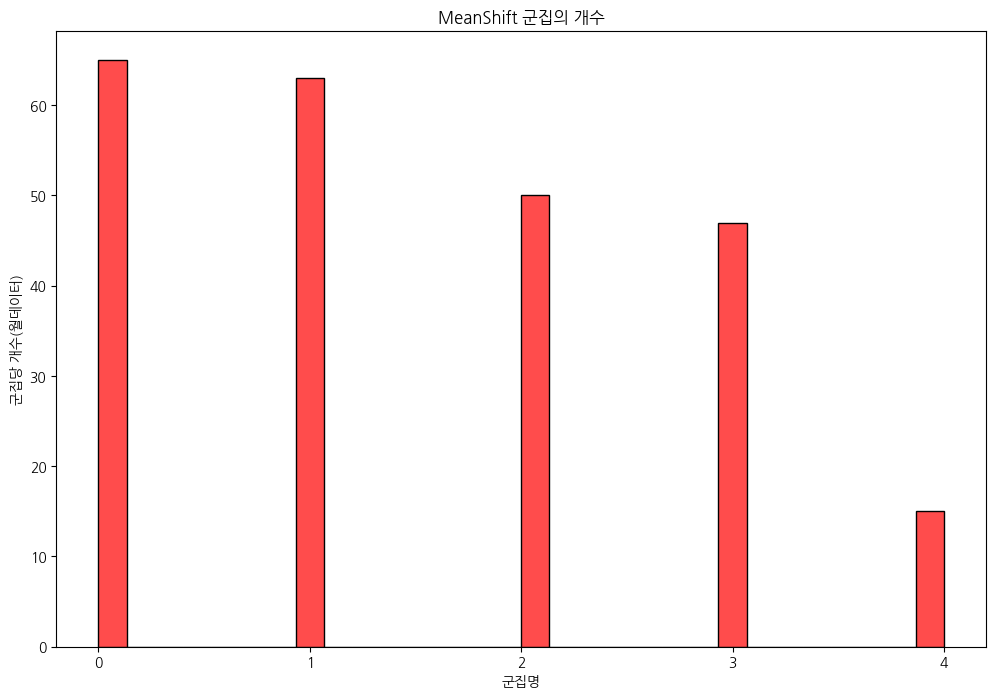

In [69]:
# menashift 군집화 결과를 시각화
import seaborn as sns
# Seaborn 히스토그램 그리기

a=  mMscaled_data['MeanShift_cluster']
plt.figure(figsize=(12, 8))
ax1 = sns.histplot(a, bins=30, kde=False, color='red', alpha=0.7)

# x축 눈금을 정수로 바꾸는 함수
def format_func(value, tick_number):
    return int(value)

# x축 눈금에 함수 적용
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))


# 그래프 제목과 축 레이블 추가
plt.title('MeanShift 군집의 개수')
plt.xlabel('군집명')
plt.ylabel('군집당 개수(월데이터)')


# 그래프 보이기
plt.show()

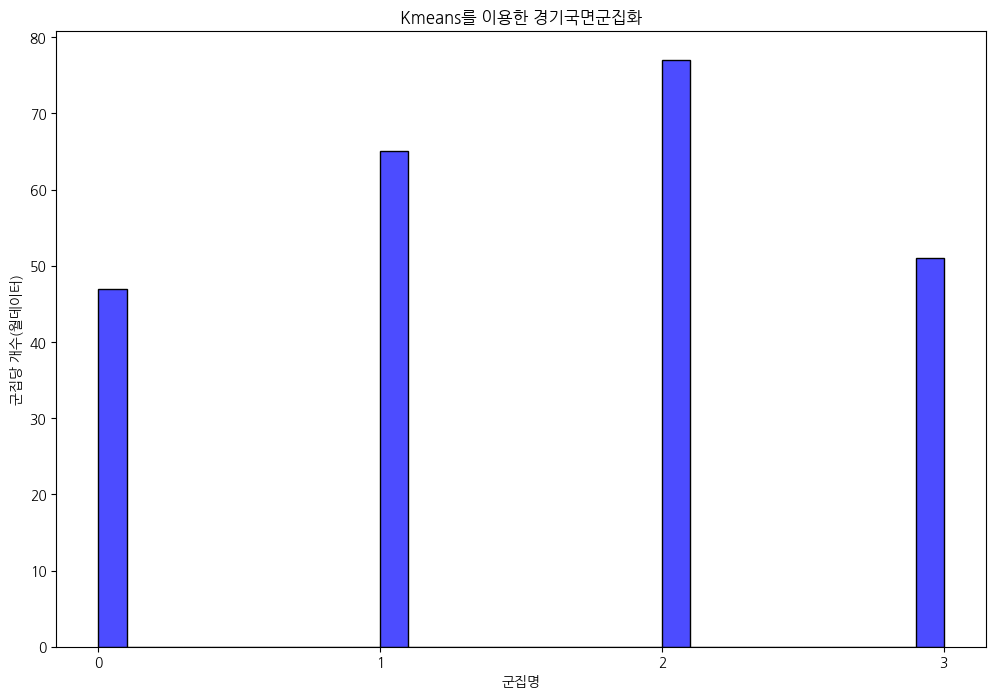

In [70]:
# k-means 군집화의 클러스터를 시각화
import matplotlib.ticker as ticker
# Seaborn 히스토그램 그리기
b=  mMscaled_data['cluster'].astype(int)


# Seaborn 히스토그램 그리기
plt.figure(figsize=(12, 8))
ax = sns.histplot(b, bins=30, kde=False, color='blue', alpha=0.7)

# x축 눈금을 정수로 바꾸는 함수
def format_func(value, tick_number):
    return int(value)

# x축 눈금에 함수 적용
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# 그래프 제목과 축 레이블 추가
plt.title('Kmeans를 이용한 경기국면군집화')
plt.xlabel('군집명')
plt.ylabel('군집당 개수(월데이터)')

# 그래프 보이기
plt.show()
